In [1]:
import numpy as np
import pandas as pd
import joblib

import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt
from scipy.signal import hamming

import librosa
import os
import math
import numpy as np
import csv
from scipy.signal import find_peaks

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score

import scipy as sp

def creare_cepstrum(semnal, frecv_esant):
    cadru_size = semnal.size  #dimensiunea ferestrei este agala cu numarul de elemente ale semnalului
    fereastra_semnal = np.hamming(cadru_size) * semnal  #semnalul se inmulteste cu o fereastra hamming de aceeasi marime
    dt = 1/frecv_esant  
    freq_vector = np.fft.rfftfreq(cadru_size, d=dt)
    X = np.fft.rfft(fereastra_semnal)
    log_X = np.log(np.abs(X))
    cepstrum = np.fft.rfft(log_X)
    df = freq_vector[1] - freq_vector[0]
    quefrency_vector = np.fft.rfftfreq(log_X.size, df)
    
    return quefrency_vector, cepstrum

def cepstrum_f0_detectie(semnal, frecv_esant):
    #se creaza cepstrumul
    quefrency_vector, cepstrum = creare_cepstrum(semnal, frecv_esant)
    
    # se extrage pitch-ul din cepstrum dintr-o regiune valida
    valid = (quefrency_vector > 1/1200) & (quefrency_vector <= 1/100) #avem doar frecvente intre 200 si 1100 Hz
    max_quefrency_index = np.argmax(np.abs(cepstrum)[valid]) #se extrage valoarea maxima din cepstrum
    f0 = 1/quefrency_vector[valid][max_quefrency_index]  #pitch-ul este egal 1 supra valoarea maxima din vectorul de valori valide
    return f0


def get_file_paths(dirname):
    file_paths = []  
    for root, directories, files in os.walk(dirname):
        for filename in files:
            filepath = os.path.join(root, filename)
            file_paths.append(filepath)  
    return file_paths

def note_index_to_note_octave(note_index):
        notes = ['A', 'A#', 'B', 'C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#']

        note = (note_index - 1) % len(notes)
        note = notes[note]

        octave = (note_index + 8) // len(notes)

        return note, octave
        
def freq_to_note_index(freq):
        if not freq:  # no log value for 0
            freq += 1e-15
        # formula taken from https://en.wikipedia.org/wiki/Piano_key_frequencies
        note_index = 12 * math.log2(freq / 440) + 49
        offset_from_note = note_index
        note_index = round(note_index)
        offset_from_note -= note_index
        nota = note_index_to_note_octave(note_index)
        return nota

def process_file(y, sr=22050):
    med = sp.signal.medfilt(y, 21) #am aplicat filtru de mediere
    # plt.figure(figsize=(14, 5))
    # librosa.display.waveplot(y, sr=sr)

    pitch = cepstrum_f0_detectie(med, sr)
    # print(pitch)
    # print(pitch, "hz")
    #
    # plt.figure(figsize=(14,5))
    # plt.plot(corr[:10000])
    # plt.plot(peaks[top], corr[peaks[top]], "x")
    # plt.xlabel('Lag (samples)')
    # plt.xlim(0, 10000)
    # plt.show()
        
    nota = freq_to_note_index(pitch)
    nota = ''.join(map(str, nota))

    # print(nota, pitch)
    
    return nota, pitch


def generare_onseturi(fisier_wav):
    y, sr = librosa.load(fisier_wav)
    print(sr)  #rata de esnationare
    print(len(y))  #y = duratata semnal in secunde * rata de esantionare sr
    #durata = len(y)/sr

    plt.figure(figsize=(14,5))
    librosa.display.waveshow(y, sr=sr)

    o_env = librosa.onset.onset_strength(y=y, sr=sr)
    times = librosa.times_like(o_env, sr=sr)
    onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)

    print(onset_frames) # frame numbers of estimated onsets

    onset_times = librosa.frames_to_time(onset_frames)
    print(onset_times)

    y_db = 10.0 * np.log10(y)

    plt.figure(figsize=(10,5))
    librosa.display.waveshow(y, sr=sr)
    plt.vlines(onset_times, -0.3, 0.3, color = 'r')
    
    return y, sr, onset_times
    
# cadre onset-uri
def cepstrum_onseturi(fisier_wav, fisier_csv):
    y, sr, onset_times = generare_onseturi(fisier_wav)
    durata = len(y) / sr
    timpi = np.arange(0, durata, 1/sr)
    dictionar = {}
    nr_esantion = [i for i in range(1, len(y) + 1)]
    for i in range(len(nr_esantion)):
        dictionar[nr_esantion[i]] = timpi[i]

    cadre = []
    for i in range(len(onset_times)):
        onset1 = onset_times[i]
        try:
            onset2 = onset_times[i+1]
        except IndexError:
            onset2 = timpi[-1]
        cadru_curent = []
        for j in range(len(y)):
            if j in dictionar:
                if dictionar[j] > onset1: 
                    if dictionar[j] < onset2:
                        cadru_curent.append(j)
                    else:
                        break
        cadre.append(cadru_curent)

    # fiecare onset are o lista de esantioane
    esantioane_onset = []
    for i in range(len(cadre)):
        esantioane_onset.append(y[cadre[i][0] : cadre[i][-1]])

    # note aferente fiecarui onset  
    note = []
    frecvente = []
    for i in esantioane_onset:
        nota, pitch = process_file(i)
#         print(nota, pitch)
        note.append(nota)
        frecvente.append(pitch)

    with open(fisier_csv, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['pitch', 'nota'])
        randuri = []
        for i,j in zip(frecvente, note):
            randuri.append([i, j])
        writer.writerows(randuri)
        
    return 0


22050
383260
[  7  18  30  42  54  66  77  90 102 112 124 136 152 169 195 208 219 230
 240 252 263 274 286 297 308 319 335 351 388 401 412 423 434 446 457 467
 477 487 497 512 527 549 561 571 581 593 604 615 626 637 648 659 686 707
 727]
[ 0.16253968  0.41795918  0.69659864  0.9752381   1.25387755  1.53251701
  1.78793651  2.08979592  2.36843537  2.60063492  2.87927438  3.15791383
  3.52943311  3.92417234  4.52789116  4.82975057  5.08517007  5.34058957
  5.57278912  5.85142857  6.10684807  6.36226757  6.64090703  6.89632653
  7.15174603  7.40716553  7.77868481  8.15020408  9.0093424   9.31120181
  9.56662132  9.82204082 10.07746032 10.35609977 10.61151927 10.84371882
 11.07591837 11.30811791 11.54031746 11.88861678 12.2369161  12.7477551
 13.02639456 13.2585941  13.49079365 13.76943311 14.02485261 14.28027211
 14.53569161 14.79111111 15.04653061 15.30195011 15.92888889 16.41650794
 16.88090703]


C:\Users\User\AppData\Local\Temp/ipykernel_8400/2946065073.py:118: RuntimeWarning: invalid value encountered in log10
  y_db = 10.0 * np.log10(y)
D:\Installed\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(
D:\Installed\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:887: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=1
  warnings.warn(


array(['B3', 'B3', 'B3', 'C4', 'C4', 'A3', 'G3', 'C4', 'C4', 'A3', 'G3',
       'C4', 'D4', 'D4', 'B3', 'B3', 'B3', 'C4', 'C4', 'A3', 'G3', 'C4',
       'C4', 'A3', 'G3', 'C4', 'D4', 'D4', 'C4', 'C4', 'A4', 'A4', 'G4',
       'G4', 'E4', 'E4', 'D4', 'C4', 'E4', 'G4', 'E4', 'B3', 'B3', 'B3',
       'C4', 'C4', 'A3', 'G3', 'C4', 'C4', 'A3', 'G3', 'D4', 'B3', 'C4'],
      dtype='<U3')

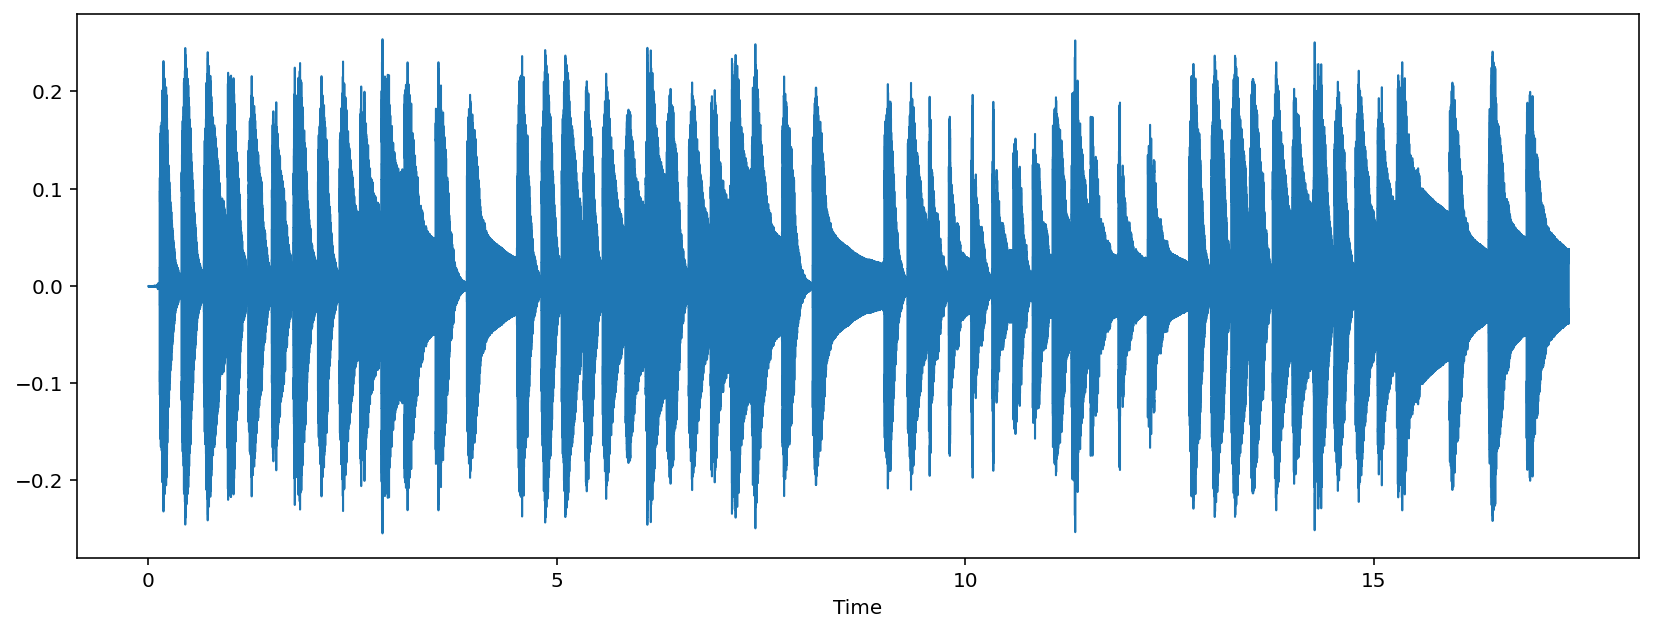

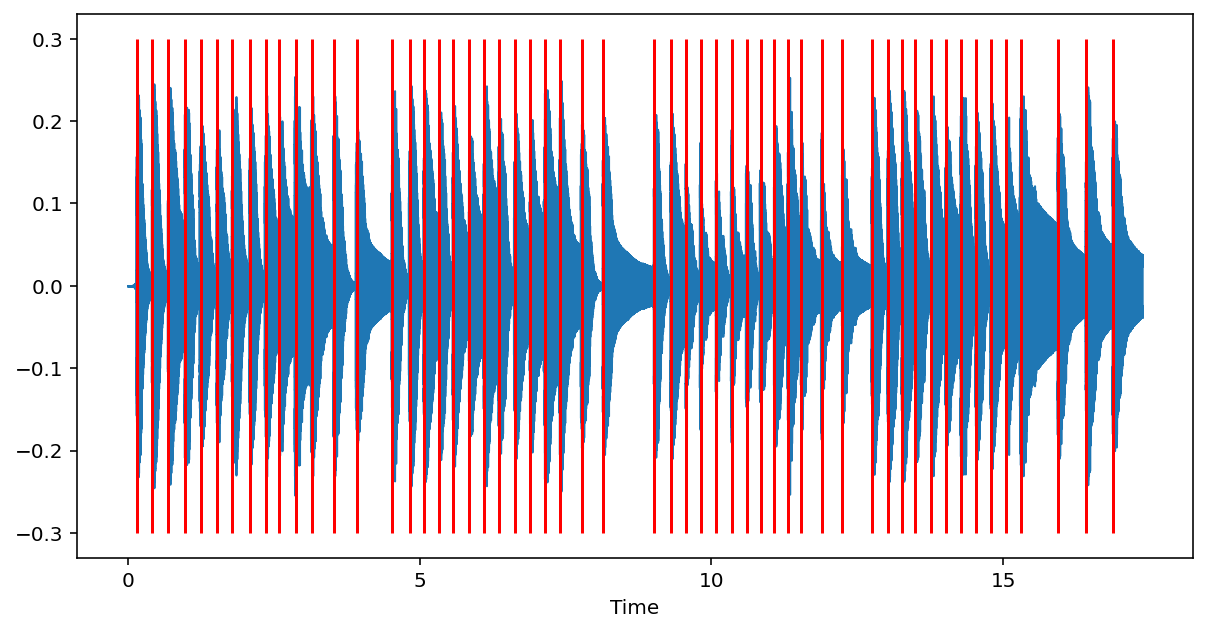

In [10]:
fisier_antrenare = 'cepstrum_trainsitest.csv'
fisier_wav = 'whistle3.wav'
fisier_csv = 'whistle3.csv'
# 
cepstrum_onseturi(fisier_wav, fisier_csv)
# 

df = pd.read_csv(fisier_antrenare)
nume_fisiere = df.iloc[:, 0].values
frecvente = df.iloc[:, 1].values                     

df_semnal = pd.read_csv(fisier_csv)
frecvente_semnal = df_semnal.iloc[:, 0].values
index_frecvente_semnal = frecvente.shape[0]

frecvente = np.append(frecvente, frecvente_semnal)
X = frecvente  
X = X.reshape(-1,1)
kmeans = MiniBatchKMeans(n_clusters=37)
kmeans.fit(X)
clustere = kmeans.fit_predict(X)

y = [nume_fisiere[i][:3] if nume_fisiere[i][2] == "#" else nume_fisiere[i][:2] for i in range(len(nume_fisiere))]
le = LabelEncoder()
y_et = le.fit_transform(y)

dictionar = {}
clustere_unice = np.unique(clustere)
clustere_fara_clustere_semnal = clustere[:index_frecvente_semnal]
for i in range(len(clustere_unice)):
    masca = np.where(clustere_fara_clustere_semnal == i, 1, 0)
    aparitii_etichete = np.bincount(y_et[masca==1])
    try:
        eticheta_aleasa = aparitii_etichete.argmax()
    except ValueError:
        print('Eroare index cluster', i)
    dictionar[i] = eticheta_aleasa

clustere_semnal = clustere[index_frecvente_semnal:]
clustere_semnal_clase = np.random.rand(len(clustere_semnal))
for i in range(len(clustere_semnal)):
    clustere_semnal_clase[i] = dictionar[clustere_semnal[i]]
    
clustere_semnal_clase = np.array([int(i) for i in clustere_semnal_clase])
clustere_semnal_clase_inv = le.inverse_transform(clustere_semnal_clase)
clustere_semnal_clase_inv.tolist()
predictii = clustere_semnal_clase_inv
predictii

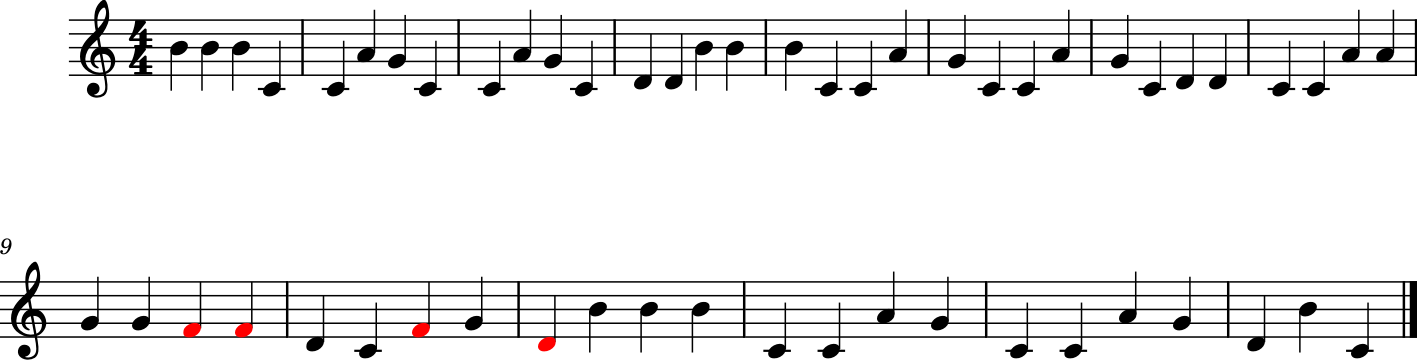

In [3]:
from music21 import *

note_prezise = predictii

note_corecte = ['B3','B3','B3','C4','C4','A3','G3','C4','C4','A3','G3','C4','D4','D4','B3','B3','B3','C4','C4','A3',
                      'G3','C4','C4','A3','G3','C4','D4','D4','C4','C4','A4','A4','G4','G4','E4','E4','D4','C4','E4','G4',
                      'E4','B3','B3','B3','C4','C4','A3','G3','C4','C4','A3','G3','D4','B3','C4']


s = stream.Stream()
for i, j in zip(note_prezise, note_corecte):
        if i[0] != j[0]:
            n = note.Note(i[0], quarterLength = 1)
            n.style.color='red'
            s.append([n])
        else:
            n = note.Note(i[0], quarterLength = 1)
            s.append([n])
    
s.show()

In [4]:
# old

In [5]:
# clustere

In [6]:
# y = [nume_fisiere[i][:3] if nume_fisiere[i][2] == "#" else nume_fisiere[i][:2] for i in range(len(nume_fisiere))]
# le = LabelEncoder()
# y_et = le.fit_transform(y)

# dictionar = {}
# clustere_unice = np.unique(clustere)
# clustere_fara_clustere_semnal = clustere[:index_frecvente_semnal]
# for i in range(len(clustere_unice)):
#     masca = np.where(clustere_fara_clustere_semnal == i, 1, 0)
#     aparitii_etichete = np.bincount(y_et[masca==1])
#     eticheta_aleasa = aparitii_etichete.argmax()
#     dictionar[i] = eticheta_aleasa
    
# dictionar

In [7]:
# clustere_semnal = clustere[index_frecvente_semnal:]
# clustere_semnal

In [8]:
# clustere_semnal_clase = np.random.rand(len(clustere_semnal))
# for i in range(len(clustere_semnal)):
#     clustere_semnal_clase[i] = dictionar[clustere_semnal[i]]

# clustere_semnal_clase

In [9]:
# clustere_semnal_clase = np.array([int(i) for i in clustere_semnal_clase])
# clustere_semnal_clase_inv = le.inverse_transform(clustere_semnal_clase)
# clustere_semnal_clase_inv.tolist()

Text(0.5, 1.0, 'C4')

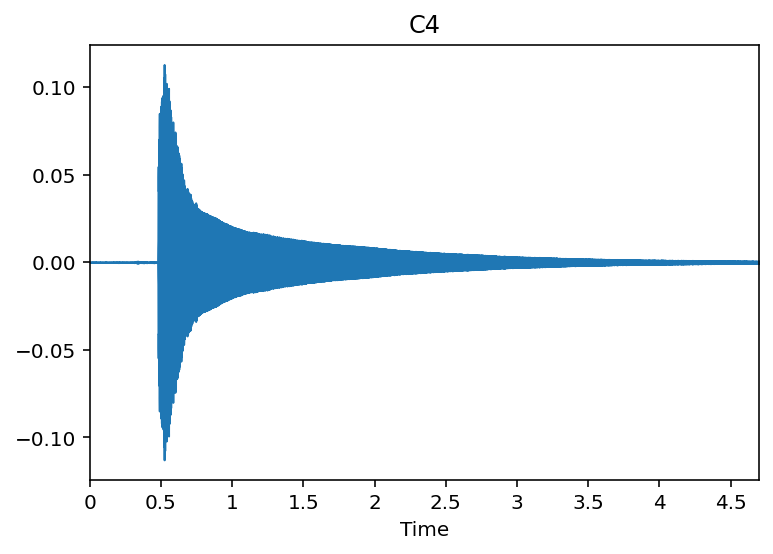

In [15]:
import matplotlib.pyplot as plt
file = r"D:\GitHub\Notes-Recognition-Using-Neural-Networks\procesare\note_trainsitest\C4.wav"
y, sr = librosa.load(file)
plt.figure()
librosa.display.waveplot(y, sr=sr)
plt.title('C4')

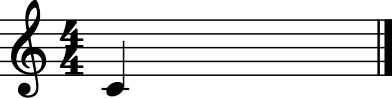

In [16]:
s = stream.Stream()

n = note.Note('C4', quarterLength = 1)

s.append([n])

    
s.show()